In [1]:
from pathlib import Path
import pandas as pd
from IPython.display import display

# Directory with per-run outputs from svg_eval.py
base_dir = Path('/Users/andrew/Developer/Prefix/prefix-rl/eval')

# Collect all stats summary files
stats_files = sorted(base_dir.glob('*/stats_summary.csv'))
stats_files


[PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-Instruct/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-7B-Instruct/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_claude-opus-4-1-20250805/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_darknoon_svg-stack-filtered-sft-qwen2.5-vl-7b-trl-10k/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_gpt-4o-2024-11-20/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_gpt-5/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_o3/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_openrouter_

In [2]:
def guess_dataset(run_dir: str) -> str:
    if run_dir.startswith('darknoon_svg-stack-filtered'):
        return 'svg-stack'
    elif run_dir.startswith('darknoon_simple-shapes-svg'):
        return 'simple-shapes'
    else:
        raise ValueError(f"Unknown dataset: {run_dir}")

# Load and annotate frames (derive dataset/model directly from folder name)
frames: list[pd.DataFrame] = []
for csv_path in stats_files:
    df = pd.read_csv(csv_path)
    run_dir = csv_path.parent.name

    # Normalize legacy column names
    if 'metric' not in df.columns and 'reward_key' in df.columns:
        df = df.rename(columns={'reward_key': 'metric'})

    if 'metric' not in df.columns:
        print(f"Skipping {csv_path} because it doesn't have a metric/reward_key column")
        continue

    df['run_dir'] = run_dir
    df["dataset"] = guess_dataset(run_dir)
    
    frames.append(df)

[f'{frame["model_name"][0]}|{frame["dataset"][0]}' for frame in frames]

['Qwen/Qwen2.5-VL-3B-Instruct|simple-shapes',
 'Qwen/Qwen2.5-VL-7B-Instruct|simple-shapes',
 'claude-opus-4-1-20250805|simple-shapes',
 'darknoon/svg-stack-filtered-sft-qwen2.5-vl-7b-trl-10k|simple-shapes',
 'gpt-4o-2024-11-20|simple-shapes',
 'gpt-5|simple-shapes',
 'o3|simple-shapes',
 'openrouter/horizon-beta|simple-shapes',
 'z-ai/glm-4.5v|simple-shapes',
 'Qwen/Qwen2.5-VL-3B-Instruct|svg-stack',
 'Qwen/Qwen2.5-VL-7B-Instruct|svg-stack',
 'claude-opus-4-20250514|svg-stack',
 'darknoon/svg-stack-filtered-sft-qwen2.5-vl-7b-trl-10k|svg-stack',
 'gpt-4o-2024-11-20|svg-stack',
 'gpt-5|svg-stack',
 'o3|svg-stack',
 'z-ai/glm-4.5v|svg-stack']

In [3]:
# Concatenate and save combined CSV
all_stats = pd.concat(frames, ignore_index=True)
all_stats[all_stats['metric'] == 'l2']

,model_name,dataset,metric,mean,std,min,max,run_dir
0,Qwen/Qwen2.5-VL-3B-Instruct,simple-shapes,l2,1.2555,0.2357,0.7872,1.7848,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...
12,Qwen/Qwen2.5-VL-7B-Instruct,simple-shapes,l2,1.2756,0.2354,0.8218,1.8156,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-7B-...
24,claude-opus-4-1-20250805,simple-shapes,l2,0.6709,0.3873,0.1116,1.4484,darknoon_simple-shapes-svg_claude-opus-4-1-202...
36,darknoon/svg-stack-filtered-sft-qwen2.5-vl-7b-...,simple-shapes,l2,1.0940,0.4045,0.3277,1.8850,darknoon_simple-shapes-svg_darknoon_svg-stack-...
48,gpt-4o-2024-11-20,simple-shapes,l2,1.2055,0.2883,0.6614,1.8351,darknoon_simple-shapes-svg_gpt-4o-2024-11-20
60,gpt-5,simple-shapes,l2,0.7300,0.3258,0.1258,1.4932,darknoon_simple-shapes-svg_gpt-5
72,o3,simple-shapes,l2,0.8111,0.2902,0.3978,1.4177,darknoon_simple-shapes-svg_o3
84,openrouter/horizon-beta,simple-shapes,l2,0.4847,0.2450,0.1282,0.8400,darknoon_simple-shapes-svg_openrouter_horizon-...
96,z-ai/glm-4.5v,simple-shapes,l2,1.0481,0.2648,0.4918,1.7507,darknoon_simple-shapes-svg_z-ai_glm-4.5v
108,Qwen/Qwen2.5-VL-3B-Instruct,svg-stack,l2,1.3033,0.1739,0.9992,1.5584,darknoon_svg-stack-filtered_Qwen_Qwen2.5-VL-3B...


In [4]:
# Clean and normalize model display names
# - drop leading 'claude-'
# - drop trailing dates like -20240101 or _20240101
# - normalize separators
# - ensure 'opus 4.1' formatting
import re

# LUT for pretty model names: (regex, replacement or callable)
_PRETTY_MODEL_REGEX_LUT = [
    (re.compile(r"^claude-opus-4-1(?:[-_]?20\d{6})?$", re.I), "opus\n4.1"),
    (re.compile(r"^claude-opus-4(?:[-_]?20\d{6})?$", re.I), "opus\n4"),
    (
        re.compile(r"^gpt 4\.1(-(mini|nano))?$", re.I),
        lambda m: f"gpt 4.1{(' ' + m.group(2).title()) if m.group(2) else ''}",
    ),
    (re.compile(r"^gpt-4o-*", re.I), "gpt 4o"),
    (re.compile(r"^openrouter/horizon-beta$", re.I), "gpt 5\n(pre)"),
    (re.compile(r"^Qwen/Qwen2\.5-VL-3B-Instruct$", re.I), "qwen\n2.5-vl-3b"),
    (re.compile(r"^Qwen/Qwen2\.5-VL-7B-Instruct$", re.I), "qwen\n2.5-vl-7b"),
    (re.compile(r"^z-ai/glm-4\.5v$", re.I), "glm 4.5v"),
    (re.compile(r"^darknoon/svg-stack-filtered-sft-qwen2.5-vl-7b-trl-10k$", re.I), "qwen (SFT)\n2.5-vl-7b"),
]


def pretty_model_name(name: str) -> str:
    for pat, pretty in _PRETTY_MODEL_REGEX_LUT:
        m = pat.match(name)
        if m:
            return pretty(m) if callable(pretty) else pretty
    return name

print(pretty_model_name("claude-opus-4-1-20240101"))
print(pretty_model_name("gpt-4o-20240806"))

opus
4.1
gpt 4o


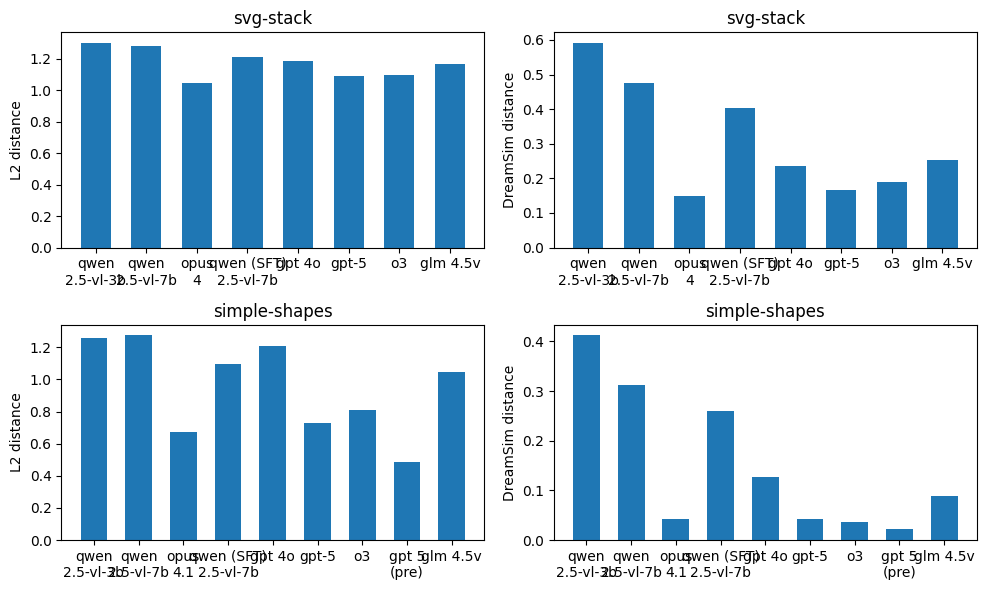

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2x2 SVG charts: rows = datasets (svg-stack, simple-shapes), cols = metrics (l2 | dreamsim)
# from matplotlib_inline import backend_inline
# backend_inline.set_matplotlib_formats('svg')

# Prepare data
row_datasets = [
    ("darknoon/svg-stack-filtered", "svg-stack"),
    ("darknoon/simple-shapes-svg", "simple-shapes"),
]
col_metrics = [
    ("l2", "L2 distance"),
    ("dreamsim", "DreamSim distance"),
]

# Determine width based on max number of models across all panes
def models_for(dataset: str, metric: str):
    dfm = (
        all_stats[(all_stats['dataset'] == dataset) & (all_stats['metric'] == metric)]
        [["model_name", "mean", "std"]]
        .sort_values("model_name")
        .copy()
    )
    dfm["model_name"] = dfm["model_name"].map(pretty_model_name)
    dfm["mean"] = pd.to_numeric(dfm["mean"], errors="coerce")
    dfm["std"] = pd.to_numeric(dfm["std"], errors="coerce").fillna(0.0)
    return dfm

max_models = 1
for d, _ in row_datasets:
    for m, _ in col_metrics:
        max_models = max(max_models, len(models_for(d, m)))

fig_width = max(10, max_models * 0.8)
fig, axes = plt.subplots(nrows=len(row_datasets), ncols=len(col_metrics), figsize=(fig_width, 6), squeeze=False)

for r, (dataset_full, guess_dataset) in enumerate(row_datasets):
    for c, (metric, metric_label) in enumerate(col_metrics):
        ax = axes[r][c]
        dfm = models_for(guess_dataset, metric)
        models = dfm["model_name"].tolist()
        vals = dfm["mean"].astype(float).values
        # errs = dfm["std"].astype(float).values
        x = np.arange(len(models))
        ax.bar(x, vals, width=0.6, capsize=3, ecolor="black", error_kw={"elinewidth": 1, "alpha": 0.6})
        ax.set_title(guess_dataset)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=0, ha="center")
        ax.set_ylabel(metric_label)
        # ax.set_title()

plt.tight_layout()
plt.show()



In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

# Load raw per-sample scores from all llm_responses.jsonl files
base_dir = Path('/Users/andrew/Developer/Prefix/prefix-rl/eval')
jsonl_files = sorted(base_dir.rglob('llm_responses.jsonl'))

# Map run_dir -> model_name from aggregated stats if available
run_dir_to_model: dict[str, str] = {}
try:
    if 'all_stats' in globals():
        tmp = all_stats[['run_dir', 'model_name']].drop_duplicates()
        run_dir_to_model = dict(tmp.values)
except Exception:
    pass


def infer_model_from_run_dir(run_dir: str) -> str:
    # Prefer value pulled from stats if present
    if run_dir in run_dir_to_model:
        return run_dir_to_model[run_dir]
    # Heuristic fallback from folder name
    dataset_token = 'simple-shapes-svg' if 'simple-shapes' in run_dir else 'svg-stack-filtered'
    parts = run_dir.split(dataset_token, 1)
    model_part = parts[-1]
    if model_part.startswith('_'):
        model_part = model_part[1:]
    # Convert known vendor prefixes to vendor/name
    for vendor in ('Qwen_', 'openrouter_', 'VLM-Reasoner_', 'LMM-R1-MGT-PerceReason_'):
        if model_part.startswith(vendor):
            model_part = model_part.replace('_', '/', 1)
            break
    return model_part

rows: list[pd.DataFrame] = []
for path in jsonl_files:
    run_dir = path.parent.name
    guess_dataset = 'svg-stack' if 'svg-stack' in run_dir else 'simple-shapes'
    model_name = infer_model_from_run_dir(run_dir)

    try:
        df = pd.read_json(path, lines=True)
    except ValueError:
        # Fallback manual parse
        with open(path, 'r') as f:
            df = pd.DataFrame([json.loads(line) for line in f if line.strip()])

    for metric in ('l2', 'dreamsim'):
        if metric not in df.columns:
            continue
        sub = df[['id', metric]].copy()
        sub['value'] = pd.to_numeric(sub[metric], errors='coerce')
        sub = sub[sub['value'].notna()]
        sub['metric'] = metric
        sub['dataset'] = guess_dataset
        sub['run_dir'] = run_dir
        sub['model_name'] = model_name
        rows.append(sub[['id', 'dataset', 'run_dir', 'model_name', 'metric', 'value']])

raw_scores = (
    pd.concat(rows, ignore_index=True)
    if rows
    else pd.DataFrame(columns=['id', 'dataset', 'run_dir', 'model_name', 'metric', 'value'])
)

# Pretty model names if helper is available
if 'pretty_model_name' in globals():
    raw_scores['model_name_pretty'] = raw_scores['model_name'].map(pretty_model_name)
else:
    raw_scores['model_name_pretty'] = raw_scores['model_name']

display(raw_scores.head(), raw_scores.shape)


,id,dataset,run_dir,model_name,metric,value,model_name_pretty
0,0,simple-shapes,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...,Qwen/Qwen2.5-VL-3B-Instruct,l2,0.999173,qwen\n2.5-vl-3b
1,1,simple-shapes,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...,Qwen/Qwen2.5-VL-3B-Instruct,l2,0.999578,qwen\n2.5-vl-3b
2,2,simple-shapes,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...,Qwen/Qwen2.5-VL-3B-Instruct,l2,0.999590,qwen\n2.5-vl-3b
3,3,simple-shapes,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...,Qwen/Qwen2.5-VL-3B-Instruct,l2,1.362073,qwen\n2.5-vl-3b
4,4,simple-shapes,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...,Qwen/Qwen2.5-VL-3B-Instruct,l2,1.522844,qwen\n2.5-vl-3b


(4424, 7)

No data for simple-shapes l2 qwen (SFT)
2.5-vl-7b
No data for simple-shapes dreamsim qwen (SFT)
2.5-vl-7b


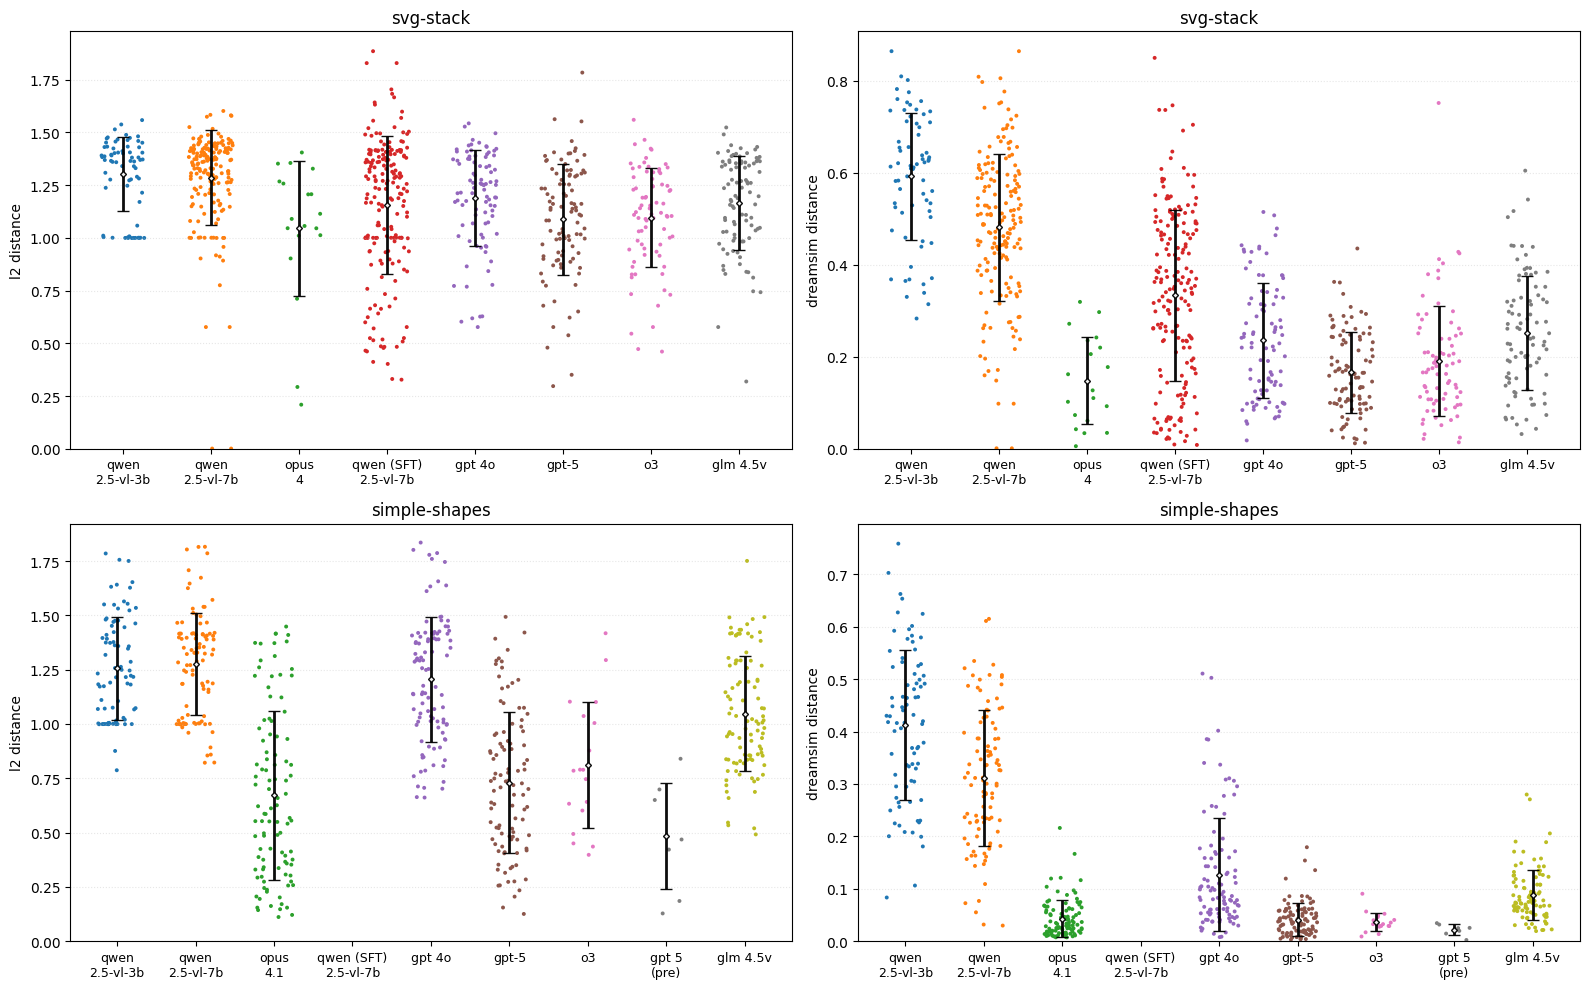

In [7]:
# Per-model distributions shown as jittered points with mean±std, in same 2x2 layout
import numpy as np
import matplotlib.pyplot as plt

row_datasets = ["svg-stack", "simple-shapes"]
col_metrics = ["l2", "dreamsim"]

# Order models to match the summary bar chart if available
def ordered_models(dataset: str, metric: str) -> list[str]:
    dfm = models_for(dataset, metric)
    # models_for returns 'model_name' pretty-formatted already
    col = 'model_name' if 'model_name' in dfm.columns else 'model_name_pretty'
    return dfm[col].tolist()

# Colors per model
try:
    import seaborn as sns  # noqa: F401
    def get_colors(n):
        return sns.color_palette("tab10", n_colors=max(3, n))
except Exception:
    import matplotlib as mpl
    def get_colors(n):
        cmap = mpl.cm.get_cmap('tab10', max(3, n))
        return [cmap(i) for i in range(max(3, n))]

# Dynamic width for readability
max_models = 1
for d in row_datasets:
    for m in col_metrics:
        max_models = max(max_models, len(ordered_models(d, m)))
fig_width = max(16, max_models * 0.8)

fig, axes = plt.subplots(nrows=len(row_datasets), ncols=len(col_metrics), figsize=(fig_width, 10), squeeze=False)

# Small floor for log scale (distances can be exactly 0)
EPS = 1e-3

for r, guess_dataset in enumerate(row_datasets):
    for c, metric in enumerate(col_metrics):
        ax: plt.Axes = axes[r][c]
        pane = raw_scores[(raw_scores['dataset'] == guess_dataset) & (raw_scores['metric'] == metric)]
        if pane.empty:
            ax.set_visible(False)
            print(f"No data for {guess_dataset} {metric}")
            continue

        models = ordered_models(guess_dataset, metric)
        x = np.arange(len(models))
        colors = get_colors(len(models))
        jitter = 0.25  # horizontal jitter for visibility

        show_legend_here = False  # no legend; labels already identify models

        for i, model in enumerate(models):
            sdf = pane[pane['model_name_pretty'] == model]
            if sdf.empty:
                print(f"No data for {guess_dataset} {metric} {model}")
                continue
            yvals = sdf['value'].to_numpy(dtype=float)
            yvals = np.clip(yvals, EPS, None)
            xs = x[i] + np.random.uniform(-jitter, jitter, size=len(yvals))

            ax.scatter(xs, yvals, s=8, alpha=1.0, color=colors[i % len(colors)], edgecolors='none')

            mu = float(np.nanmean(yvals))
            sd = float(np.nanstd(yvals))
            label = model if show_legend_here else None
            ax.errorbar(
                x[i], mu, yerr=sd,
                fmt='D', markersize=3,
                color='black', ecolor='black', elinewidth=2.0, capsize=4,
                mfc='white', mec='black', mew=1.0,
                alpha=0.95, label=label, zorder=5,
            )

        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=0, ha='center', fontsize=9)
        ax.set_ylabel(f"{metric} distance")
        ax.set_title(guess_dataset)
        ax.set_xlim(-0.6, len(models) - 0.4)
        ax.grid(True, axis='y', linestyle=':', alpha=0.3)
        # Log scale with small floor
        # ax.set_yscale('log')
        ax.set_ylim(bottom=0.0)
        # Reference line at EPS to echo baseline
        # ax.axhline(EPS, color='k', linewidth=1.0, alpha=0.4)
        # No legend; labels already identify models

plt.tight_layout()
fig.savefig("report_plot.svg", format="svg")
plt.show()
